In [1]:
from model_utils import *

In [2]:
MODEL_NAME = 'skimai/spanberta-base-cased'
FILE = 'data/elmoundo_Valid.json'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 1
CATE_LIMIT = 2
CATE_USE = 7
TASK = 'Soft-presentation'

In [3]:
import datetime
TODAY = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,TODAY)
SUB_DIR = 'Soft-Presentation'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [4]:
# load data
labels,contents,lset,ldic = load_test_data(FILE,CATE_LIMIT,percentage=1)

# encode 1 87s
start = time.time()
encodings_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print('encoding time cost :',time.time()-start)

# load dataset
val_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic,balance=[1,0,0])


# dataloader
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)


Data loaded:  14 14


100%|██████████| 14/14 [00:00<00:00, 1575.66it/s]

Tokenizer loaded...
encoding time cost : 8.980791330337524


In [5]:
MODEL_NAME = 'skimai/spanberta-base-cased'
pmodel = 'results/elmundo_on_trained-1202/3e-05-128/1202-epoch-0.pth'
model1 = 'results/elmundo_on_trained-1202/3e-05-128/1202-epoch-1.pth'
model2 = 'results/elmundo_on_trained-1202/3e-05-128/1202-epoch-2.pth'
model3 = 'results/elmundo_on_trained-1202/3e-05-128/1202-epoch-3.pth'
MODELS = [MODEL_NAME,pmodel,model1,model2,model3]
MODELNAMES = ['Raw','Further-1','Further-2','Further-3','Further-4']
CATES = [26,7,7,7,7]

In [6]:
bert_results = []
cls_results = []
tars = []
allowed_cates = [i for i in range(CATE_USE)]
for idx,(m, ca) in enumerate(zip(MODELS,CATES)):
    model = RobertaForSequenceClassification(MODEL_NAME,ca)
    if m != MODEL_NAME:
        model.load_dict(m,ca,True)
    b_result = []
    c_result = []
    lab = []
    if torch.cuda.is_available():
        model = nn.DataParallel(model)
        model.cuda()
    model.eval()
    with torch.no_grad():
        for _,data in enumerate(notetqdm(val_loader)):
            features = data['input_ids'].cuda()
            # print(features.shape)
            att_mask = data['attention_mask'].cuda()
            target = data['targets']
            if target in allowed_cates:
                # print(att_mask.shape)
                bert_out = model.module.bert(features,att_mask)
                # print(type(target))
                blist = bert_out[0].tolist()
                clist = bert_out[0][:, 0].tolist()
                tar = target.tolist()[0]
                # print(type(tar))
                b_result.append(blist)
                c_result.append(clist)
                lab.append(tar)
           
    bert_results.append(b_result)
    cls_results.append(c_result)
    tars.append(lab)

bert_results = np.array(bert_results)
cls_results = np.array(cls_results)
tars = np.array(tars)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [7]:
bert_results.shape, cls_results.shape, tars.shape

((5, 14, 1, 128, 768), (5, 14, 1, 768), (5, 14))

In [8]:
tars

array([[2, 1, 4, 0, 3, 1, 4, 5, 0, 6, 2, 5, 3, 6],
       [2, 1, 4, 0, 3, 1, 4, 5, 0, 6, 2, 5, 3, 6],
       [2, 1, 4, 0, 3, 1, 4, 5, 0, 6, 2, 5, 3, 6],
       [2, 1, 4, 0, 3, 1, 4, 5, 0, 6, 2, 5, 3, 6],
       [2, 1, 4, 0, 3, 1, 4, 5, 0, 6, 2, 5, 3, 6]])

## 2D

In [9]:
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist
colors = ['b','g','r','m','c','y']

In [10]:
mds2 = MDS(n_components=2)
trans_2d = []
for x in cls_results:
    x = np.squeeze(x)
    x_transformed = mds2.fit_transform(x)
    trans_2d.append(x)

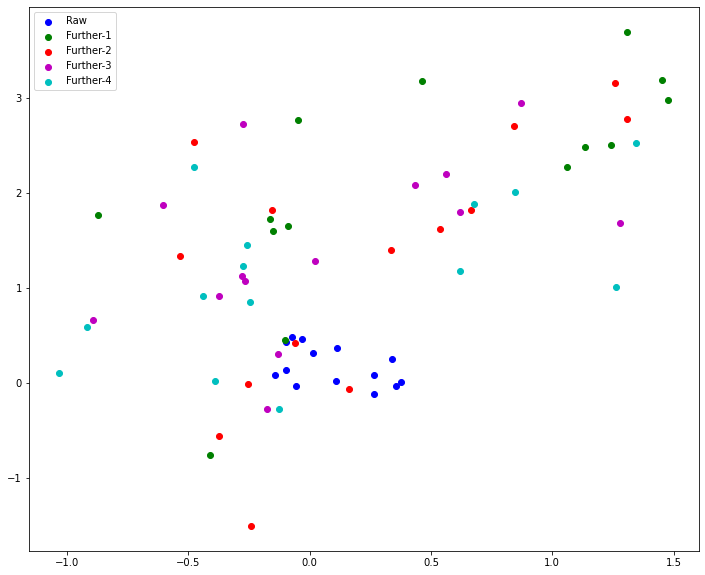

In [11]:
#colors = tuple([(np.random.random(),np.random.random(),np.random.random()) for i in range(CATE_USE)])
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
for idx,pots in enumerate(trans_2d):
    xs, ys, cs, ts = pots[:,0], pots[:,1], colors[idx], MODELNAMES[idx]
    # print(len(xs),len(ys))
    ax.scatter(xs,ys,c=cs,label=ts)
    ax.legend()
fig.savefig('2d_cluster')

## 3d

In [36]:
mds3 = MDS(n_components=3)
trans_3d = []
for x in cls_results:
    x = np.squeeze(x)
    x_transformed = mds3.fit_transform(x)
    trans_3d.append(x)

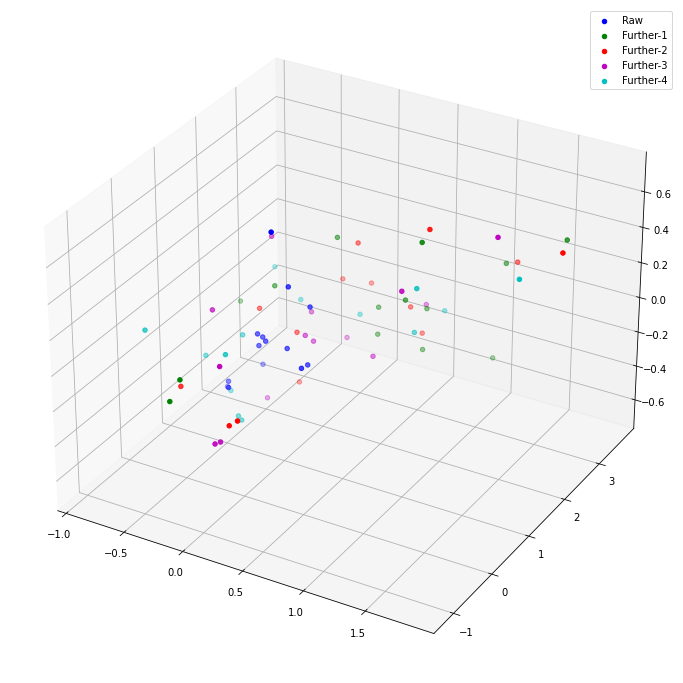

In [42]:
#colors = tuple([(np.random.random(),np.random.random(),np.random.random()) for i in range(CATE_USE)])
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
fig.subplots_adjust(top=10, bottom=-10)
for idx,pots in enumerate(trans_2d):
    xs, ys, zs, cs, ts = pots[:,0], pots[:,1], pots[:,2], colors[idx], MODELNAMES[idx]
    # print(len(xs),len(ys))
    ax.scatter(xs, ys, zs, c=cs,label=ts)
    ax.legend()
fig.savefig('3d_cluster')

In [43]:
def ClusterDist(set1,set2,dist_fun):
    len1, len2 = len(set1), len(set2)
    dists = []
    for i in range(len1):
        for j in range(len2):
            dist = dist_fun(set1[i],set2[j])
            dists.append(dist)
    return dists

In [44]:
cls_lists = []
for i in range(len(cls_results)):
    cls_lists.append([ np.squeeze(item) for item in cls_results[i]])

In [45]:
euclidean_dist = lambda a,b : np.sqrt(np.square(a-b).sum())

In [46]:
rds = []
for i in range(1, len(cls_lists)):
    rds.append(ClusterDist(cls_lists[0],cls_lists[i],euclidean_dist))

In [47]:
CLA = [ sum(d)/len(d) for d in rds]
CLA

[33.436161535325716, 33.45079936660912, 33.33454429868726, 33.29933240965462]

In [48]:
def Cosine_similarity(set1,set2):
    len1 = len(set1)
    similarity = []
    sim_func = lambda a,b : np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    for i in range(len1):
        sim = sim_func(set1[i],set2[i])
        similarity.append(sim)
    return similarity

In [49]:
css = []
for i in range(1, len(cls_lists)):
    sim = Cosine_similarity(cls_lists[0],cls_lists[i])
    css.append(sim)

In [50]:
cosines = [sum(s)/len(s) for s in css]
cosines

[0.1361652768009809,
 0.13725266235347428,
 0.1421892085414072,
 0.1435035265190909]